# Prédiction du Diabète - Dataset Pima Indians
## Approche axée sur l'interprétabilité

Ce notebook présente une analyse complète du dataset Pima avec un focus sur l'interprétabilité des modèles.

## 1. Import des bibliothèques

In [12]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métriques
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    f1_score,
    accuracy_score
)

# Gestion du déséquilibre
#from imblearn.over_sampling import SMOTE

# Interprétabilité
from sklearn.inspection import permutation_importance

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Chargement des données

In [2]:
# Charger le dataset Pima depuis l'URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(url, names=columns)

print(f"Dimensions du dataset: {df.shape}")
print(f"\nNombre de diabétiques: {df['Outcome'].sum()}")
print(f"Nombre de non-diabétiques: {(df['Outcome'] == 0).sum()}")
print(f"Pourcentage de diabétiques: {df['Outcome'].mean()*100:.2f}%")

Dimensions du dataset: (768, 9)

Nombre de diabétiques: 268
Nombre de non-diabétiques: 500
Pourcentage de diabétiques: 34.90%


In [3]:
# Aperçu des données
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
# Statistiques descriptives
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3. Analyse Exploratoire des Données (EDA)

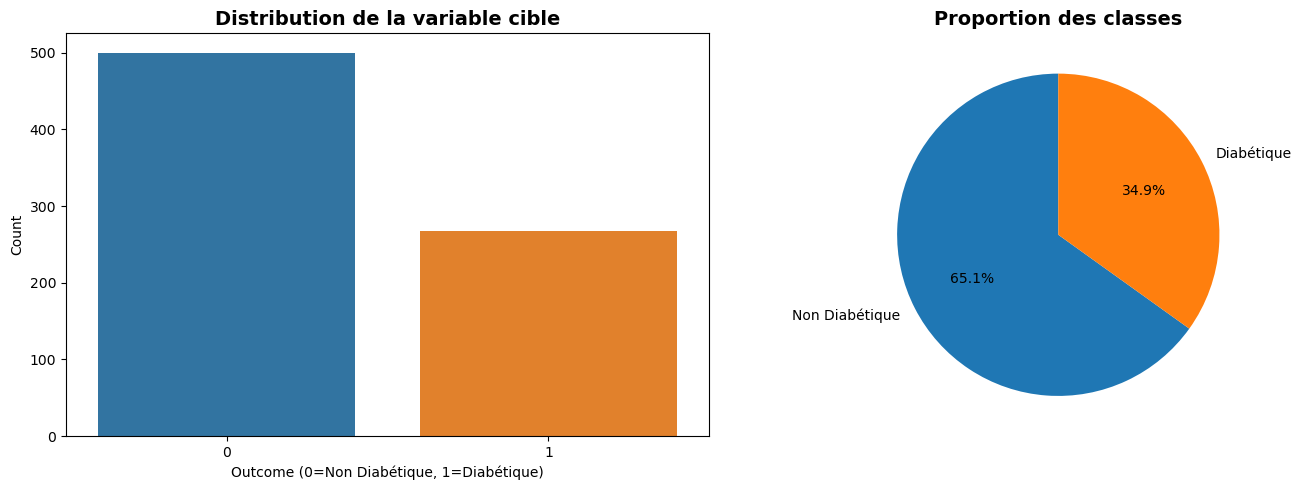

In [5]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
sns.countplot(data=df, x='Outcome', ax=axes[0])
axes[0].set_title('Distribution de la variable cible', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Outcome (0=Non Diabétique, 1=Diabétique)')
axes[0].set_ylabel('Count')

# Pie chart
outcome_counts = df['Outcome'].value_counts()
axes[1].pie(outcome_counts, labels=['Non Diabétique', 'Diabétique'], 
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proportion des classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
# Détection des valeurs nulles biologiquement impossibles
# Certaines colonnes ne peuvent pas avoir 0 comme valeur réelle
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Nombre de zéros (valeurs manquantes cachées) par colonne:")
print("="*60)
for col in zero_cols:
    n_zeros = (df[col] == 0).sum()
    pct_zeros = (n_zeros / len(df)) * 100
    print(f"{col:25s}: {n_zeros:4d} ({pct_zeros:5.2f}%)")

Nombre de zéros (valeurs manquantes cachées) par colonne:
Glucose                  :    5 ( 0.65%)
BloodPressure            :   35 ( 4.56%)
SkinThickness            :  227 (29.56%)
Insulin                  :  374 (48.70%)
BMI                      :   11 ( 1.43%)


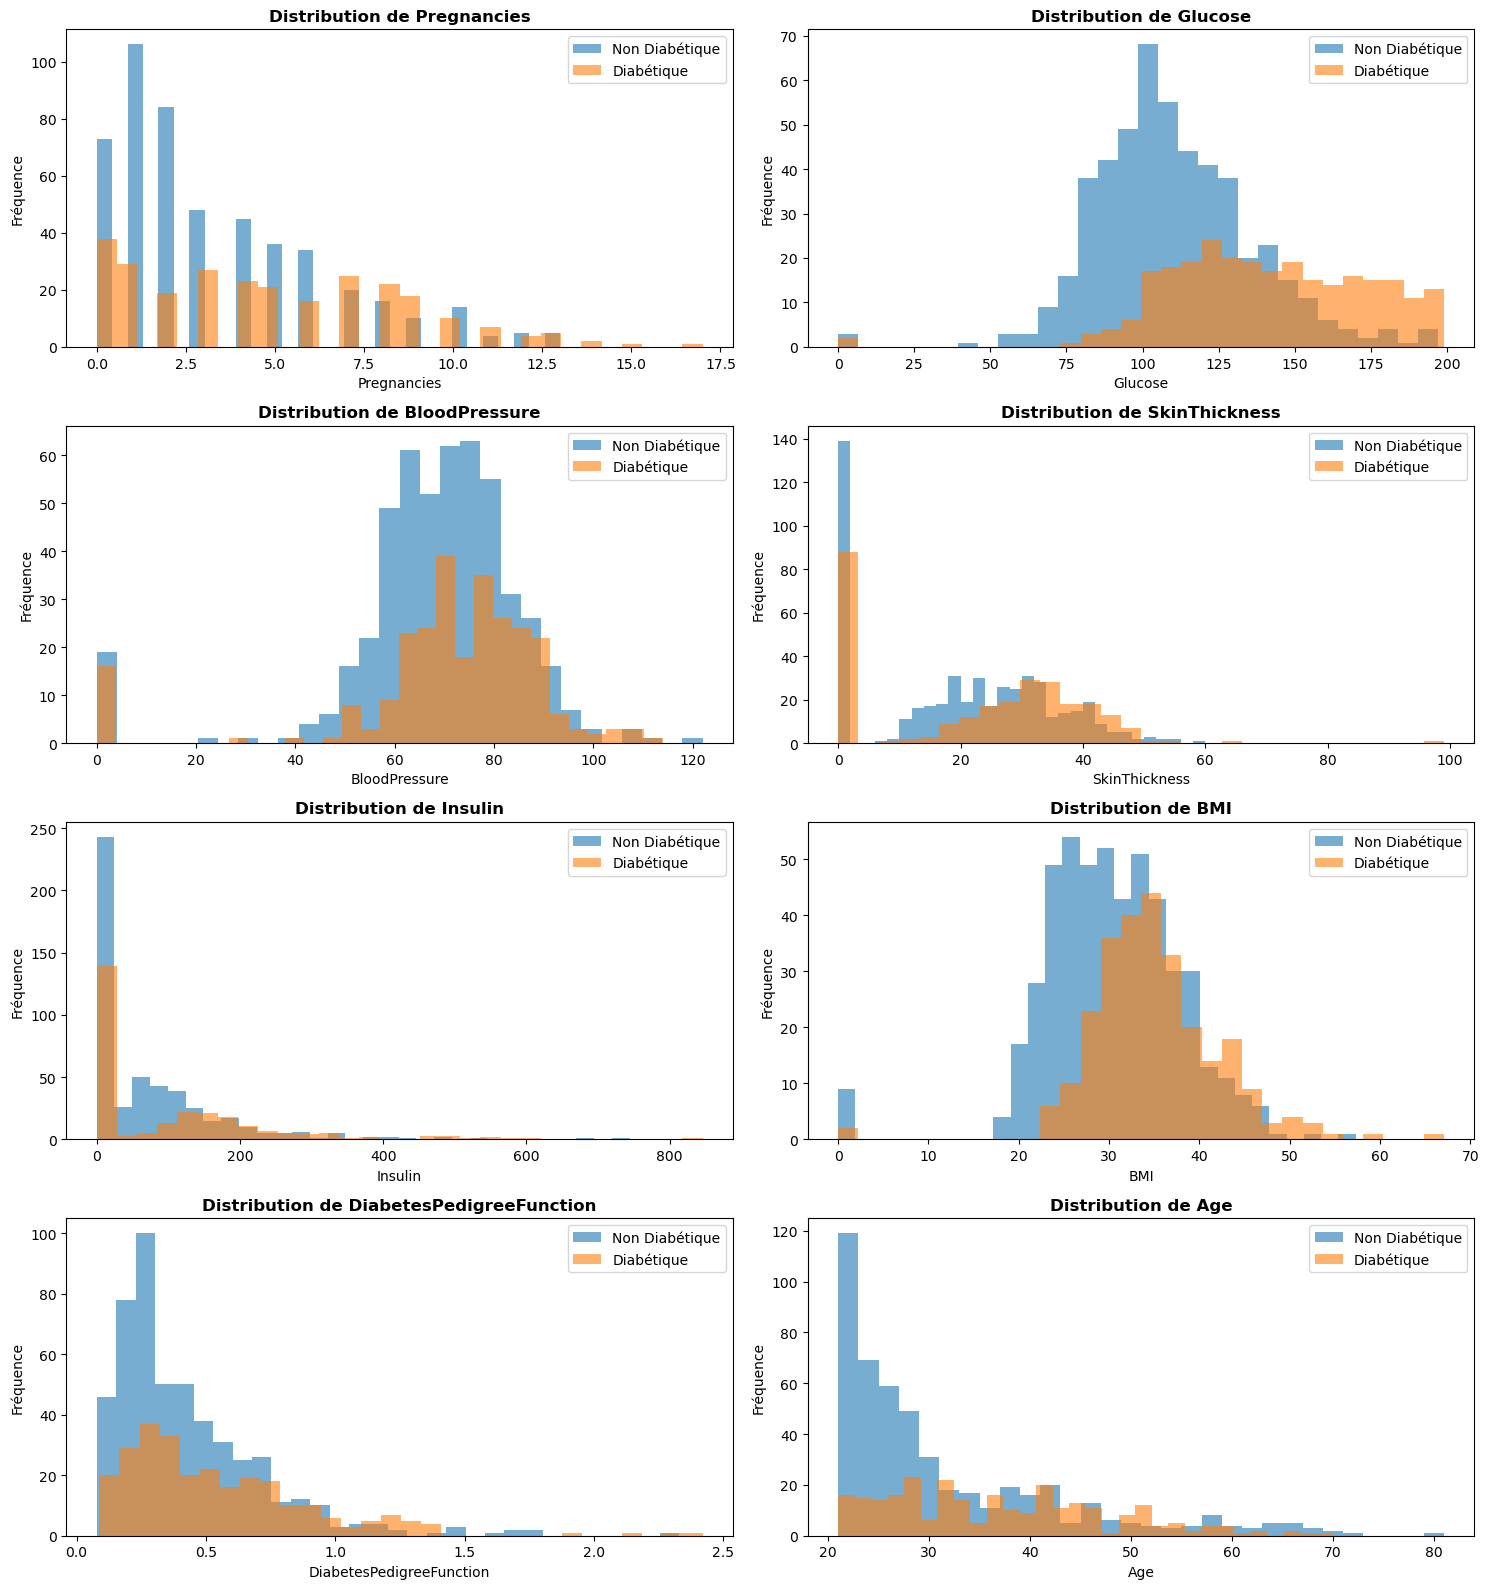

In [7]:
# Visualisation des distributions par feature
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.ravel()

features = df.columns[:-1]  # Toutes sauf Outcome

for idx, col in enumerate(features):
    axes[idx].hist(df[df['Outcome']==0][col], alpha=0.6, label='Non Diabétique', bins=30)
    axes[idx].hist(df[df['Outcome']==1][col], alpha=0.6, label='Diabétique', bins=30)
    axes[idx].set_title(f'Distribution de {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')
    axes[idx].legend()

plt.tight_layout()
plt.show()

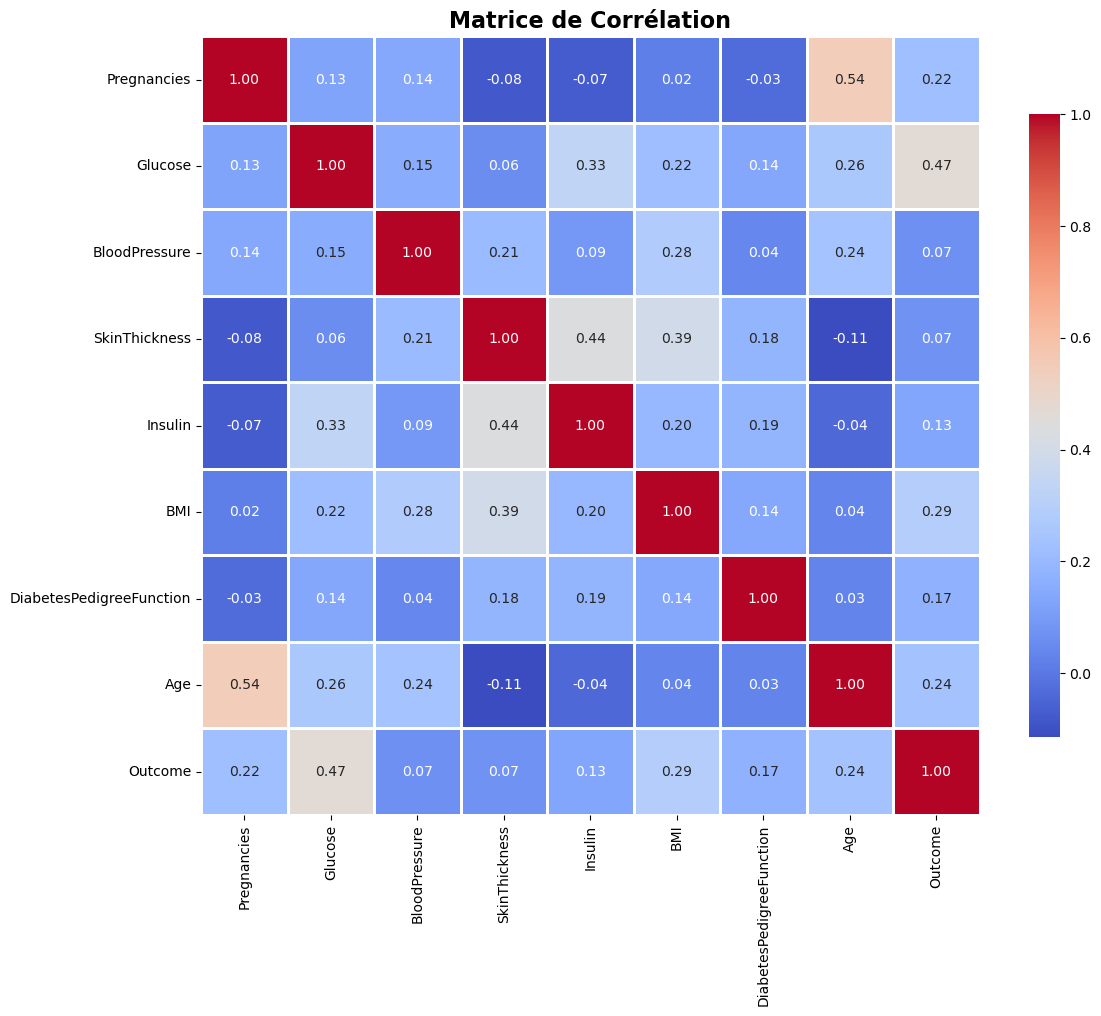


Corrélations avec la variable cible (Outcome):
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [8]:
# Matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrélations avec la variable cible (Outcome):")
print("="*50)
print(correlation_matrix['Outcome'].sort_values(ascending=False))

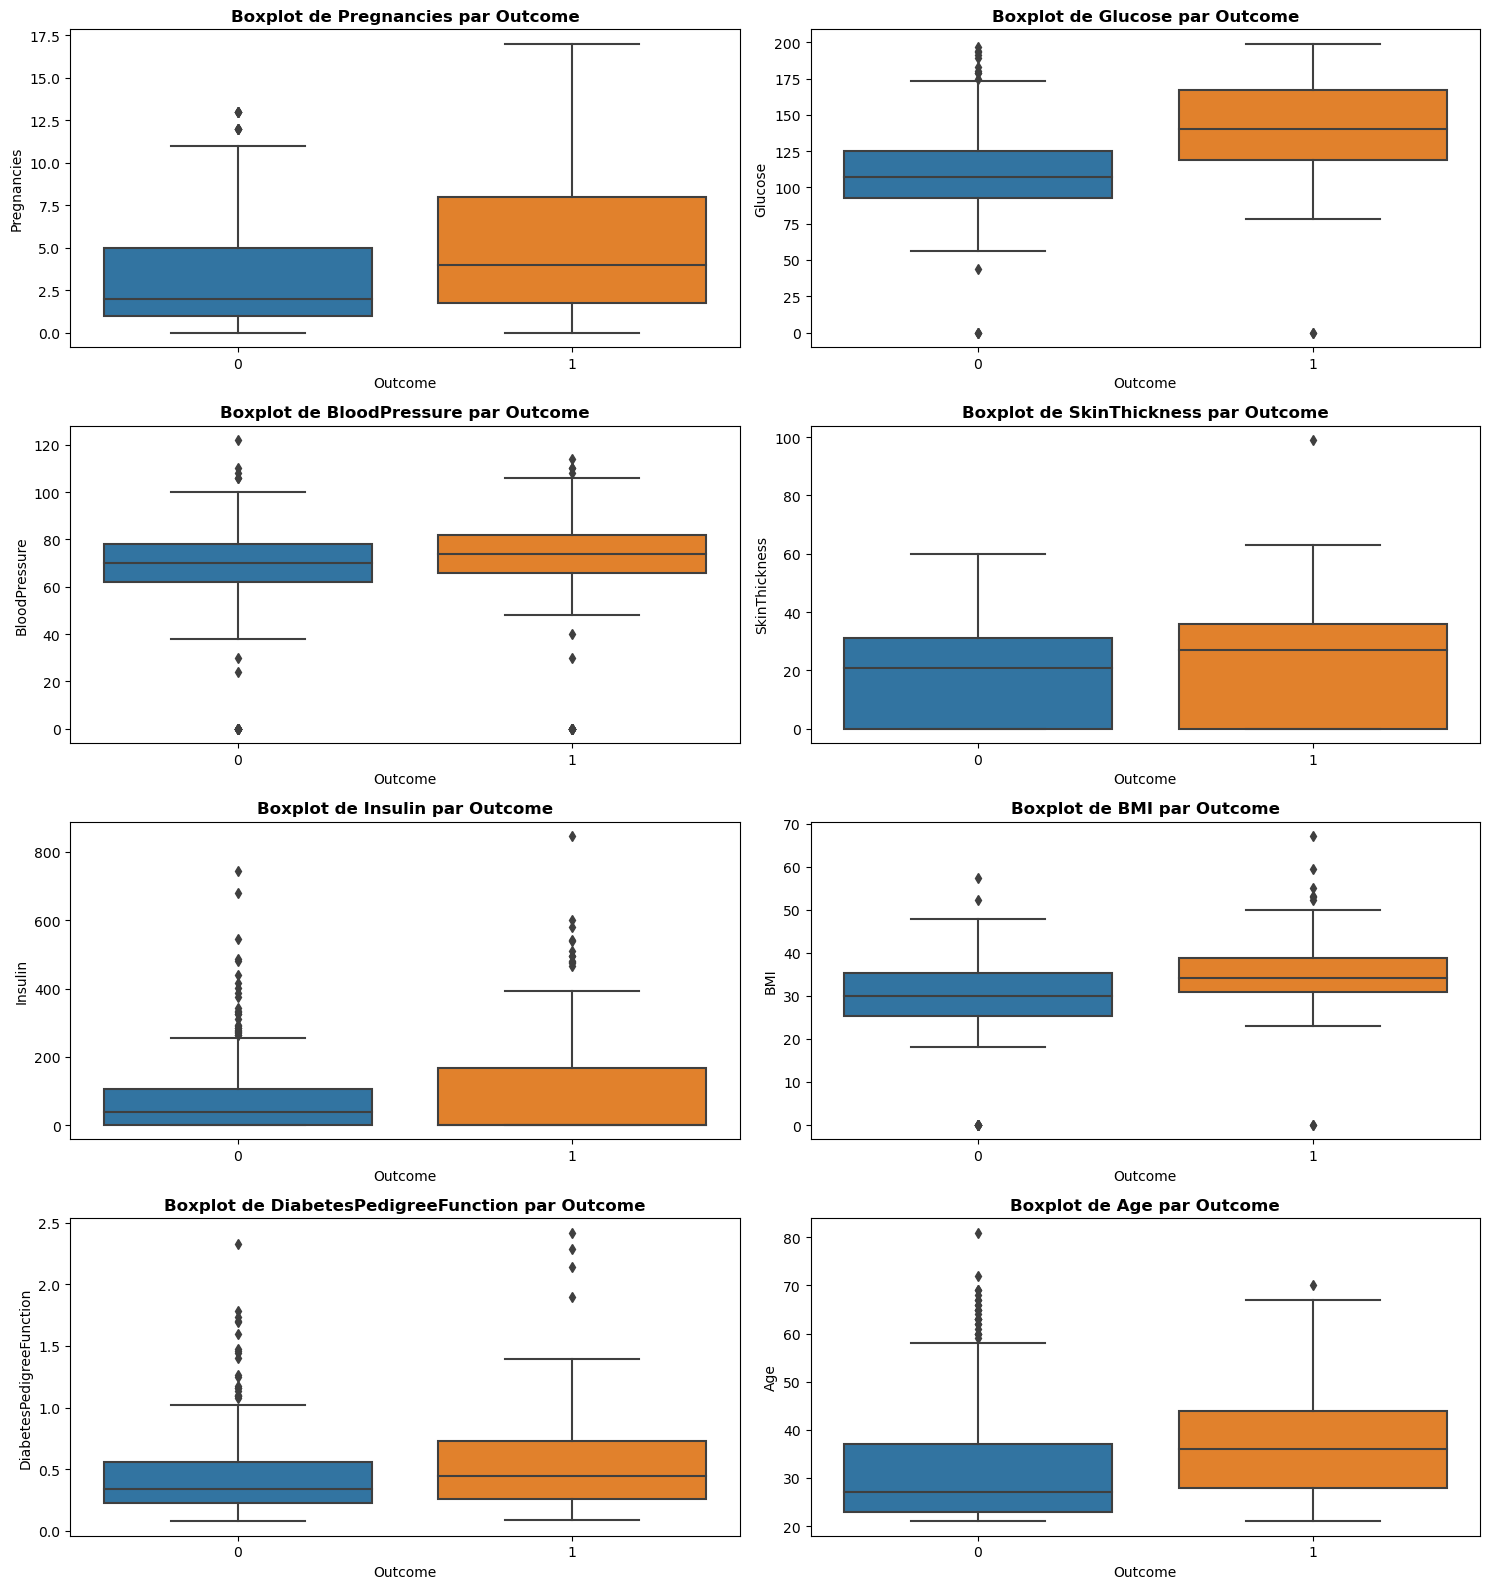

In [9]:
# Boxplots pour détecter les outliers
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.ravel()

for idx, col in enumerate(features):
    sns.boxplot(data=df, y=col, x='Outcome', ax=axes[idx])
    axes[idx].set_title(f'Boxplot de {col} par Outcome', fontweight='bold')
    axes[idx].set_xlabel('Outcome')

plt.tight_layout()
plt.show()

## 4. Preprocessing des Données

In [13]:
# Créer une copie pour le preprocessing
df_processed = df.copy()

# Remplacer les 0 par NaN pour les colonnes concernées
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_cols:
    df_processed[col] = df_processed[col].replace(0, np.nan)

print("Valeurs manquantes après remplacement des 0:")
print(df_processed.isnull().sum())

Valeurs manquantes après remplacement des 0:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [14]:
# Séparation des features et de la cible
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

# Split train/test (stratifié pour maintenir la proportion des classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Taille du train set: {X_train.shape}")
print(f"Taille du test set: {X_test.shape}")
print(f"\nDistribution train set: {y_train.value_counts().to_dict()}")
print(f"Distribution test set: {y_test.value_counts().to_dict()}")

Taille du train set: (614, 8)
Taille du test set: (154, 8)

Distribution train set: {0: 400, 1: 214}
Distribution test set: {0: 100, 1: 54}


In [15]:
# Imputation des valeurs manquantes avec la médiane (robuste aux outliers)
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Valeurs manquantes après imputation (train):")
print(X_train_imputed.isnull().sum())
print("\nValeurs manquantes après imputation (test):")
print(X_test_imputed.isnull().sum())

Valeurs manquantes après imputation (train):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Valeurs manquantes après imputation (test):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


In [16]:
# Traitement des outliers (optional, conservative approach)
# Cap aux percentiles 1 et 99 pour éviter les valeurs extrêmes
def cap_outliers(df, lower_percentile=1, upper_percentile=99):
    df_capped = df.copy()
    for col in df.columns:
        lower_bound = df[col].quantile(lower_percentile/100)
        upper_bound = df[col].quantile(upper_percentile/100)
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

# Appliquer seulement sur le train set, utiliser les mêmes bounds pour test
X_train_capped = cap_outliers(X_train_imputed)

# Pour le test set, on utilise les bounds calculés sur le train
X_test_capped = X_test_imputed.copy()
for col in X_test_capped.columns:
    lower_bound = X_train_imputed[col].quantile(0.01)
    upper_bound = X_train_imputed[col].quantile(0.99)
    X_test_capped[col] = X_test_capped[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers traités avec capping aux percentiles 1 et 99")

Outliers traités avec capping aux percentiles 1 et 99


In [17]:
# Feature Engineering (optionnel mais améliore souvent les performances)
def create_features(X):
    X_new = X.copy()
    
    # Interactions pertinentes cliniquement
    X_new['BMI_Age'] = X_new['BMI'] * X_new['Age']
    X_new['Glucose_Insulin'] = X_new['Glucose'] * X_new['Insulin']
    X_new['Glucose_BMI'] = X_new['Glucose'] * X_new['BMI']
    
    # Indicateurs de risque
    X_new['High_Risk'] = ((X_new['Age'] > 50) & (X_new['BMI'] > 30)).astype(int)
    X_new['Pregnancy_Risk'] = ((X_new['Pregnancies'] > 6) & (X_new['Age'] > 30)).astype(int)
    
    return X_new

X_train_engineered = create_features(X_train_capped)
X_test_engineered = create_features(X_test_capped)

print(f"Nouvelles dimensions après feature engineering: {X_train_engineered.shape}")
print(f"\nNouvelles features créées:")
new_features = [col for col in X_train_engineered.columns if col not in X_train_capped.columns]
print(new_features)

Nouvelles dimensions après feature engineering: (614, 13)

Nouvelles features créées:
['BMI_Age', 'Glucose_Insulin', 'Glucose_BMI', 'High_Risk', 'Pregnancy_Risk']


In [ ]:
# Standardisation (IMPORTANT: fit uniquement sur train pour éviter le data leakage)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_engineered),
    columns=X_train_engineered.columns,
    index=X_train_engineered.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_engineered),
    columns=X_test_engineered.columns,
    index=X_test_engineered.index
)


print("Données standardisées")
print(f"\nMoyenne des features (train set, devrait être ~0):")
print(X_train_scaled.mean().round(2))
print(f"\nÉcart-type des features (train set, devrait être ~1):")
print(X_train_scaled.std().round(2))

Données standardisées

Moyenne des features (train set, devrait être ~0):
Pregnancies                 0.0
Glucose                    -0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                    -0.0
BMI                        -0.0
DiabetesPedigreeFunction    0.0
Age                        -0.0
BMI_Age                     0.0
Glucose_Insulin            -0.0
Glucose_BMI                -0.0
High_Risk                  -0.0
Pregnancy_Risk             -0.0
dtype: float64

Écart-type des features (train set, devrait être ~1):
Pregnancies                 1.0
Glucose                     1.0
BloodPressure               1.0
SkinThickness               1.0
Insulin                     1.0
BMI                         1.0
DiabetesPedigreeFunction    1.0
Age                         1.0
BMI_Age                     1.0
Glucose_Insulin             1.0
Glucose_BMI                 1.0
High_Risk                   1.0
Pregnancy_Risk              1.0
dtype: float64


In [ ]:
# Gestion du déséquilibre avec SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Avant SMOTE: {y_train.value_counts().to_dict()}")
print(f"Après SMOTE: {y_train_balanced.value_counts().to_dict()}")
print(f"\nNouvelle taille du train set: {X_train_balanced.shape}")

## 5. Modélisation

Nous allons comparer deux modèles très interprétables:
1. **Logistic Regression** - Coefficients directement interprétables
2. **Random Forest** - Feature importance et facilité de visualisation

### 5.1 Logistic Regression

In [19]:
# Logistic Regression avec régularisation L2
log_reg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='liblinear'
)

# Grid Search pour trouver le meilleur C (inverse de la force de régularisation)
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_lr = GridSearchCV(
    log_reg,
    param_grid_lr,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"\nMeilleurs paramètres: {grid_lr.best_params_}")
print(f"Meilleur score AUC (CV): {grid_lr.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Meilleurs paramètres: {'C': 0.1, 'penalty': 'l1'}
Meilleur score AUC (CV): 0.8441


In [20]:
# Entraîner le meilleur modèle
best_log_reg = grid_lr.best_estimator_

# Prédictions
y_pred_lr = best_log_reg.predict(X_test_scaled)
y_pred_proba_lr = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Métriques
print("="*60)
print("LOGISTIC REGRESSION - RÉSULTATS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non Diabétique', 'Diabétique']))

LOGISTIC REGRESSION - RÉSULTATS

Accuracy: 0.7013
ROC-AUC Score: 0.8050
F1-Score: 0.5490

Classification Report:
                precision    recall  f1-score   support

Non Diabétique       0.75      0.80      0.78       100
    Diabétique       0.58      0.52      0.55        54

      accuracy                           0.70       154
     macro avg       0.67      0.66      0.66       154
  weighted avg       0.69      0.70      0.70       154



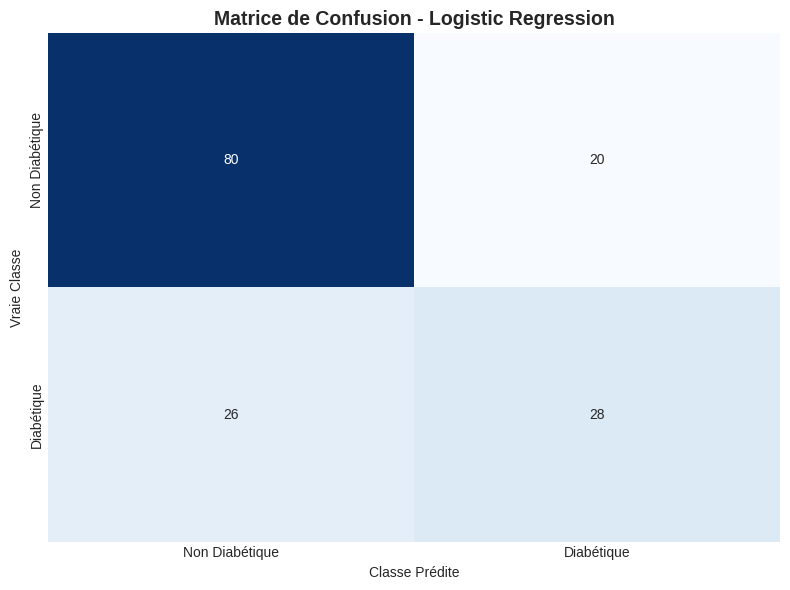

True Negatives: 80
False Positives: 20
False Negatives: 26
True Positives: 28

Sensitivity (Recall): 0.5185
Specificity: 0.8000


In [21]:
# Matrice de confusion - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

# Analyse détaillée
tn, fp, fn, tp = cm_lr.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

### 5.2 Random Forest

In [23]:
# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Grid Search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_scaled, y_train)

print(f"\nMeilleurs paramètres: {grid_rf.best_params_}")
print(f"Meilleur score AUC (CV): {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Meilleurs paramètres: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Meilleur score AUC (CV): 0.8447


In [24]:
# Entraîner le meilleur modèle
best_rf = grid_rf.best_estimator_

# Prédictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Métriques
print("="*60)
print("RANDOM FOREST - RÉSULTATS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non Diabétique', 'Diabétique']))

RANDOM FOREST - RÉSULTATS

Accuracy: 0.7273
ROC-AUC Score: 0.8135
F1-Score: 0.5800

Classification Report:
                precision    recall  f1-score   support

Non Diabétique       0.77      0.83      0.80       100
    Diabétique       0.63      0.54      0.58        54

      accuracy                           0.73       154
     macro avg       0.70      0.68      0.69       154
  weighted avg       0.72      0.73      0.72       154



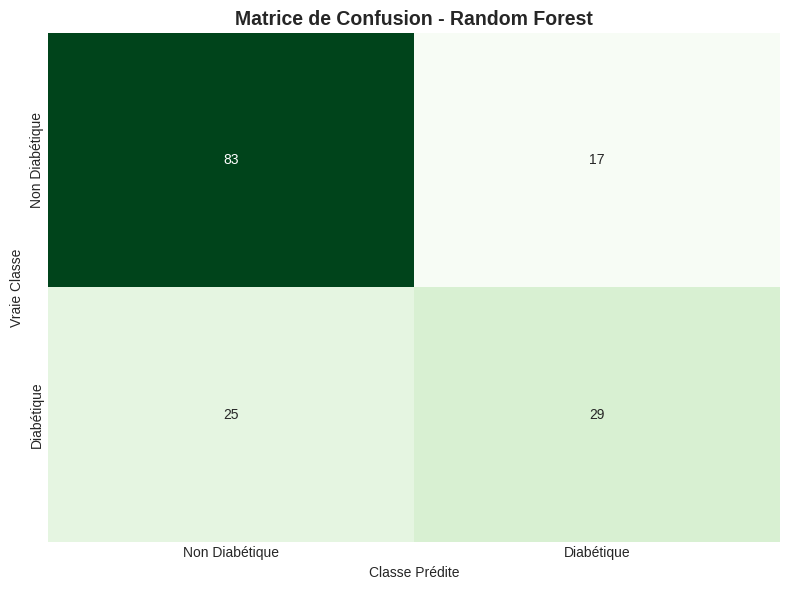

True Negatives: 83
False Positives: 17
False Negatives: 25
True Positives: 29

Sensitivity (Recall): 0.5370
Specificity: 0.8300


In [25]:
# Matrice de confusion - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

# Analyse détaillée
tn, fp, fn, tp = cm_rf.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

### 5.3 Comparaison des Modèles

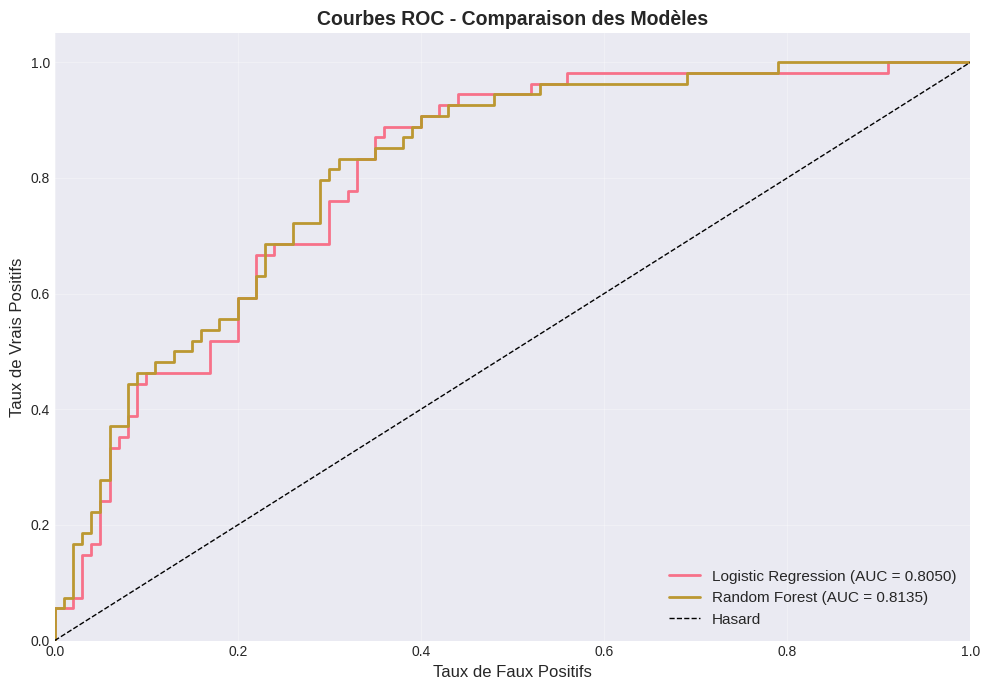

In [26]:
# Comparaison des courbes ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})', 
         linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', 
         linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Hasard', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs', fontsize=12)
plt.ylabel('Taux de Vrais Positifs', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

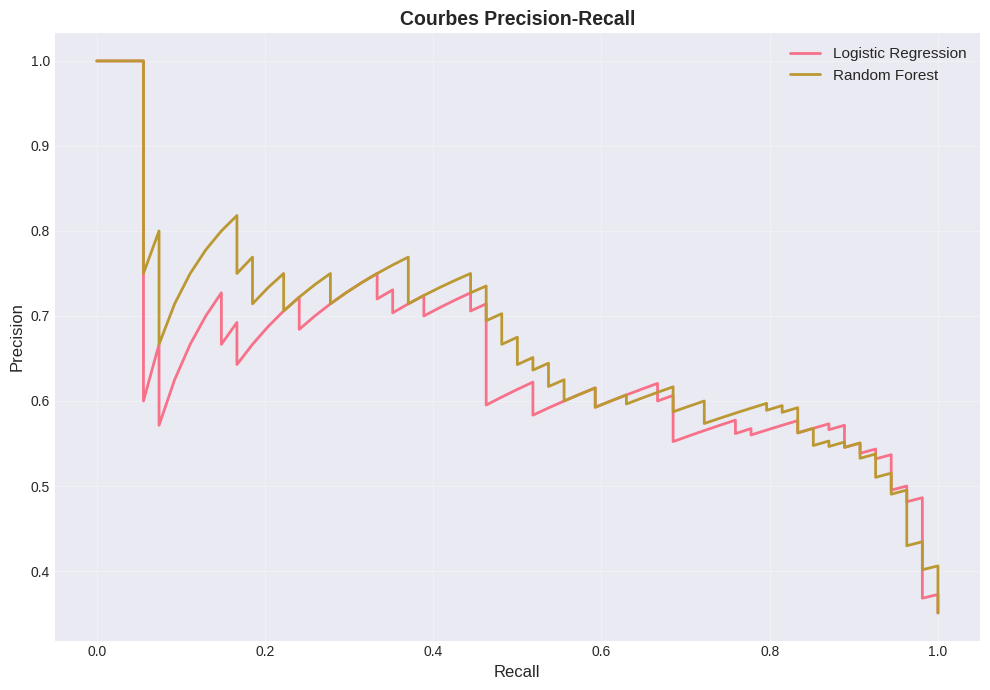

In [27]:
# Comparaison des courbes Precision-Recall
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(recall_lr, precision_lr, label='Logistic Regression', linewidth=2)
plt.plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbes Precision-Recall', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Tableau comparatif
comparison_df = pd.DataFrame({
    'Métrique': ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall'],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_proba_lr),
        f1_score(y_test, y_pred_lr),
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall']
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_pred_proba_rf),
        f1_score(y_test, y_pred_rf),
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall']
    ]
})

comparison_df['Différence'] = comparison_df['Random Forest'] - comparison_df['Logistic Regression']
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MODÈLES")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


TABLEAU COMPARATIF DES MODÈLES
 Métrique  Logistic Regression  Random Forest  Différence
 Accuracy               0.7013         0.7273      0.0260
  ROC-AUC               0.8050         0.8135      0.0085
 F1-Score               0.5490         0.5800      0.0310
Precision               0.5833         0.6304      0.0471
   Recall               0.5185         0.5370      0.0185


## 6. Interprétabilité des Modèles

### 6.1 Coefficients de la Logistic Regression


Coefficients de la Logistic Regression:
                 Feature  Coefficient  Abs_Coefficient
             Glucose_BMI     0.838765         0.838765
                 Glucose     0.429368         0.429368
          Pregnancy_Risk     0.183684         0.183684
                 BMI_Age     0.165028         0.165028
DiabetesPedigreeFunction     0.119816         0.119816
             Pregnancies     0.092562         0.092562
           BloodPressure     0.000000         0.000000
           SkinThickness     0.000000         0.000000
                 Insulin     0.000000         0.000000
                     BMI     0.000000         0.000000
                     Age     0.000000         0.000000
         Glucose_Insulin     0.000000         0.000000
               High_Risk     0.000000         0.000000


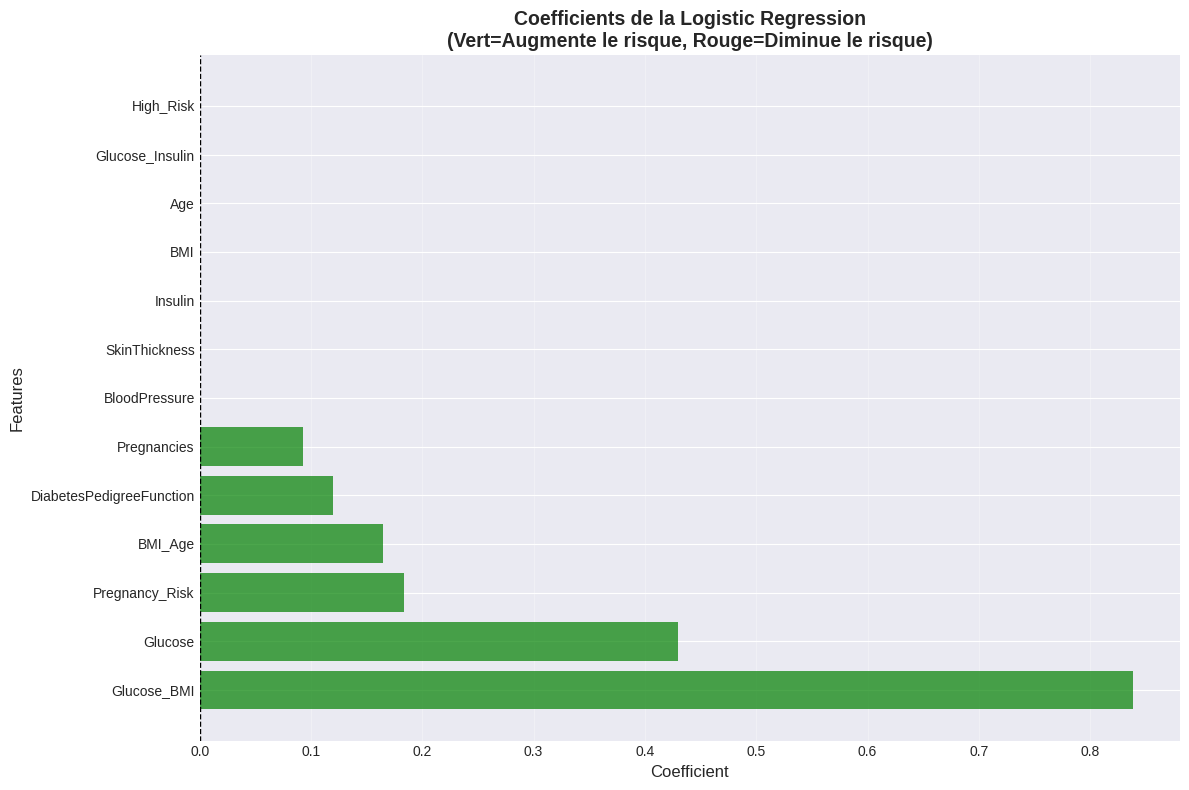

In [29]:
# Coefficients de la régression logistique
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_log_reg.coef_[0],
    'Abs_Coefficient': np.abs(best_log_reg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nCoefficients de la Logistic Regression:")
print("="*60)
print(coef_df.to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Coefficients de la Logistic Regression\n(Vert=Augmente le risque, Rouge=Diminue le risque)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Odds Ratios (plus interprétables que les coefficients bruts)
odds_ratios = np.exp(best_log_reg.coef_[0])

or_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Odds_Ratio': odds_ratios,
    'Interpretation': [
        f"+{(or-1)*100:.1f}% de risque" if or > 1 else f"{(1-or)*100:.1f}% moins de risque"
        for or in odds_ratios
    ]
}).sort_values('Odds_Ratio', ascending=False)

print("\nOdds Ratios (pour 1 écart-type d'augmentation):")
print("="*70)
print(or_df.to_string(index=False))
print("\nNote: Un Odds Ratio > 1 indique une augmentation du risque de diabète")
print("      Un Odds Ratio < 1 indique une diminution du risque de diabète")

### 6.2 Feature Importance - Random Forest


Feature Importance - Random Forest:
                 Feature  Importance
             Glucose_BMI    0.232558
                 Glucose    0.199184
         Glucose_Insulin    0.149872
                 BMI_Age    0.117989
                     BMI    0.069302
                     Age    0.067884
DiabetesPedigreeFunction    0.047628
                 Insulin    0.029951
             Pregnancies    0.027106
           BloodPressure    0.022796
           SkinThickness    0.022388
          Pregnancy_Risk    0.009640
               High_Risk    0.003703


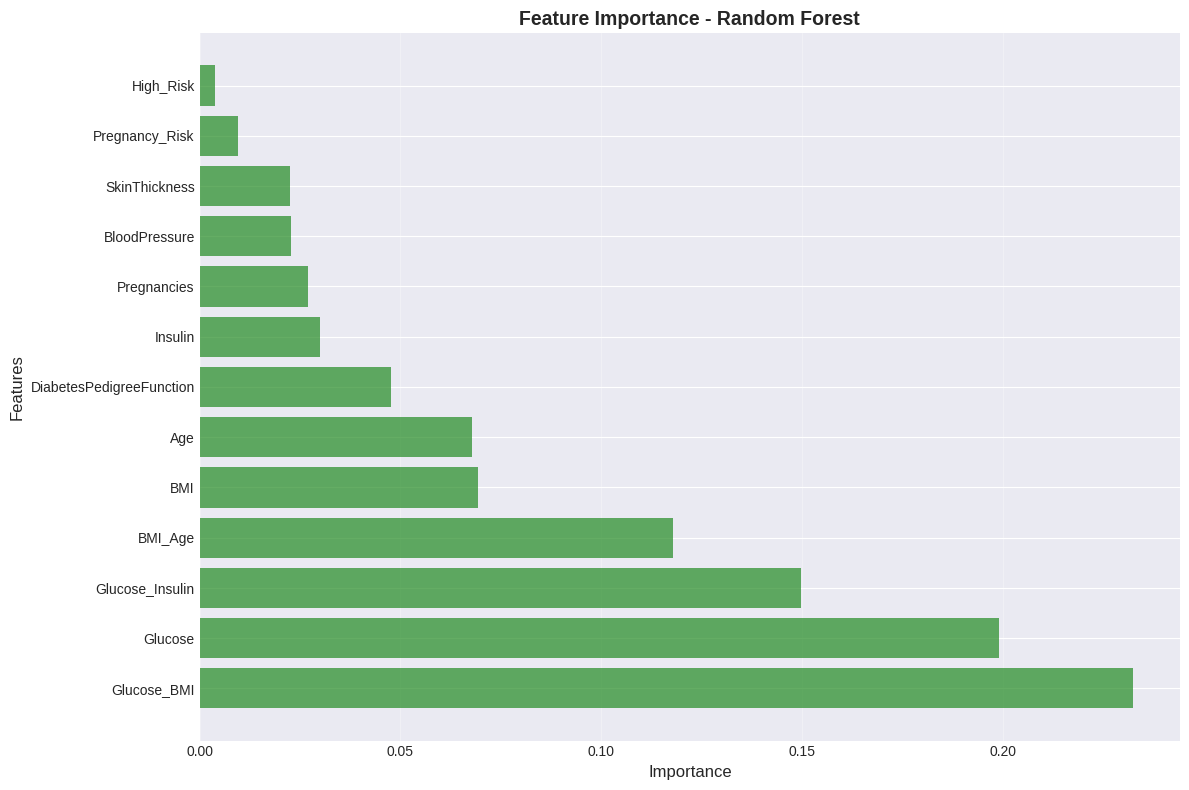

In [30]:
# Feature importance du Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance - Random Forest:")
print("="*60)
print(feature_importance_rf.to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], 
         color='forestgreen', alpha=0.7)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ratah/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Permutation Importance - Random Forest:
                 Feature  Importance_Mean  Importance_Std
                 Insulin         0.012987        0.005808
          Pregnancy_Risk         0.007143        0.005394
                     Age         0.004545        0.005072
             Pregnancies         0.003896        0.005951
               High_Risk         0.000000        0.000000
           BloodPressure        -0.000649        0.003497
           SkinThickness        -0.003247        0.003247
             Glucose_BMI        -0.003896        0.025015
                 BMI_Age        -0.004545        0.010081
                 Glucose        -0.005844        0.018007
DiabetesPedigreeFunction        -0.007143        0.011415
         Glucose_Insulin        -0.009091        0.016983
                     BMI        -0.009740        0.008832


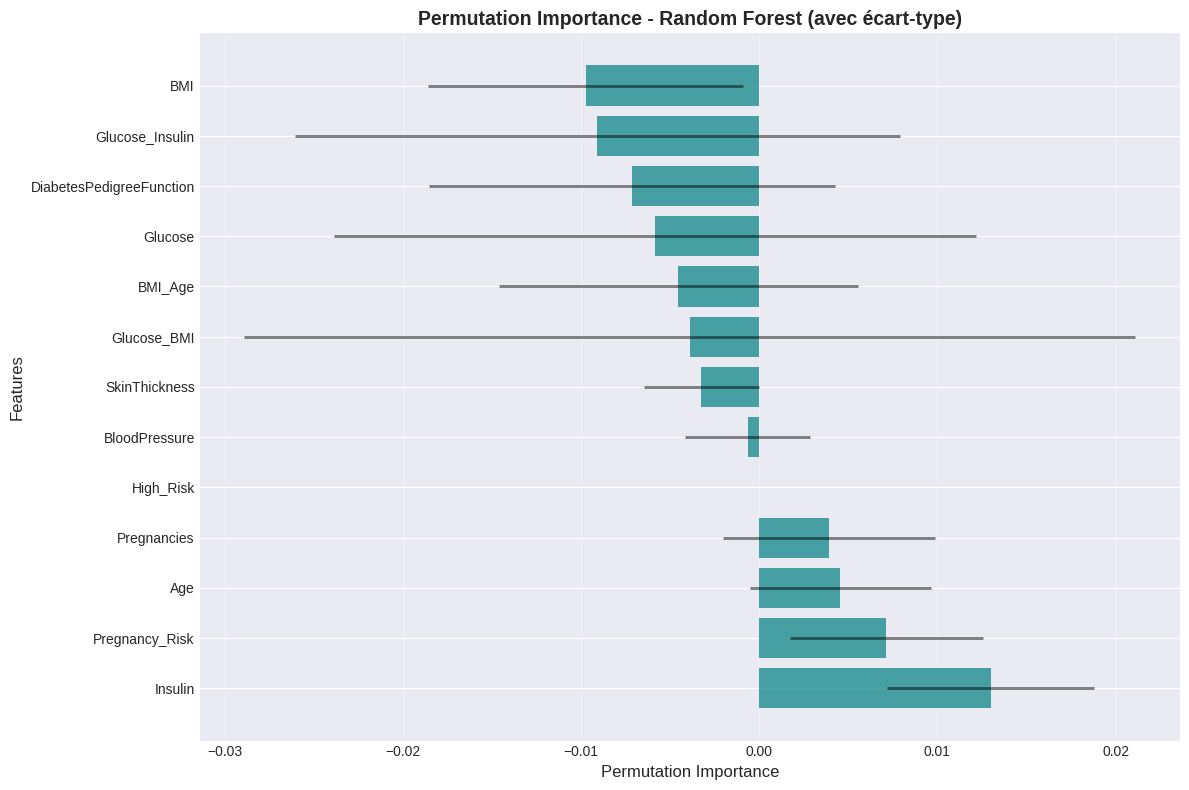

In [31]:
# Permutation Importance (plus robuste que feature_importances_)
perm_importance = permutation_importance(
    best_rf, X_test_scaled, y_test, 
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nPermutation Importance - Random Forest:")
print("="*60)
print(perm_importance_df.to_string(index=False))

# Visualisation avec barres d'erreur
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance_Mean'],
         xerr=perm_importance_df['Importance_Std'], color='teal', alpha=0.7,
         error_kw={'elinewidth': 2, 'alpha': 0.5})
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Permutation Importance - Random Forest (avec écart-type)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Comparaison des Importances


Comparaison des Importances (normalisées):
                 Feature  LR_Abs_Coef  RF_Importance  RF_Perm_Importance  Mean_Importance
             Glucose_BMI     0.458536       0.232558            0.250000         0.313698
                 Glucose     0.234727       0.199184            0.375000         0.269637
         Glucose_Insulin     0.000000       0.149872            0.583333         0.244402
                     BMI     0.000000       0.069302            0.625000         0.231434
DiabetesPedigreeFunction     0.065501       0.047628            0.458333         0.190487
                 BMI_Age     0.090217       0.117989            0.291667         0.166624
           SkinThickness     0.000000       0.022388            0.208333         0.076907
           BloodPressure     0.000000       0.022796            0.041667         0.021487
               High_Risk     0.000000       0.003703           -0.000000         0.001234
             Pregnancies     0.050602       0.027106    

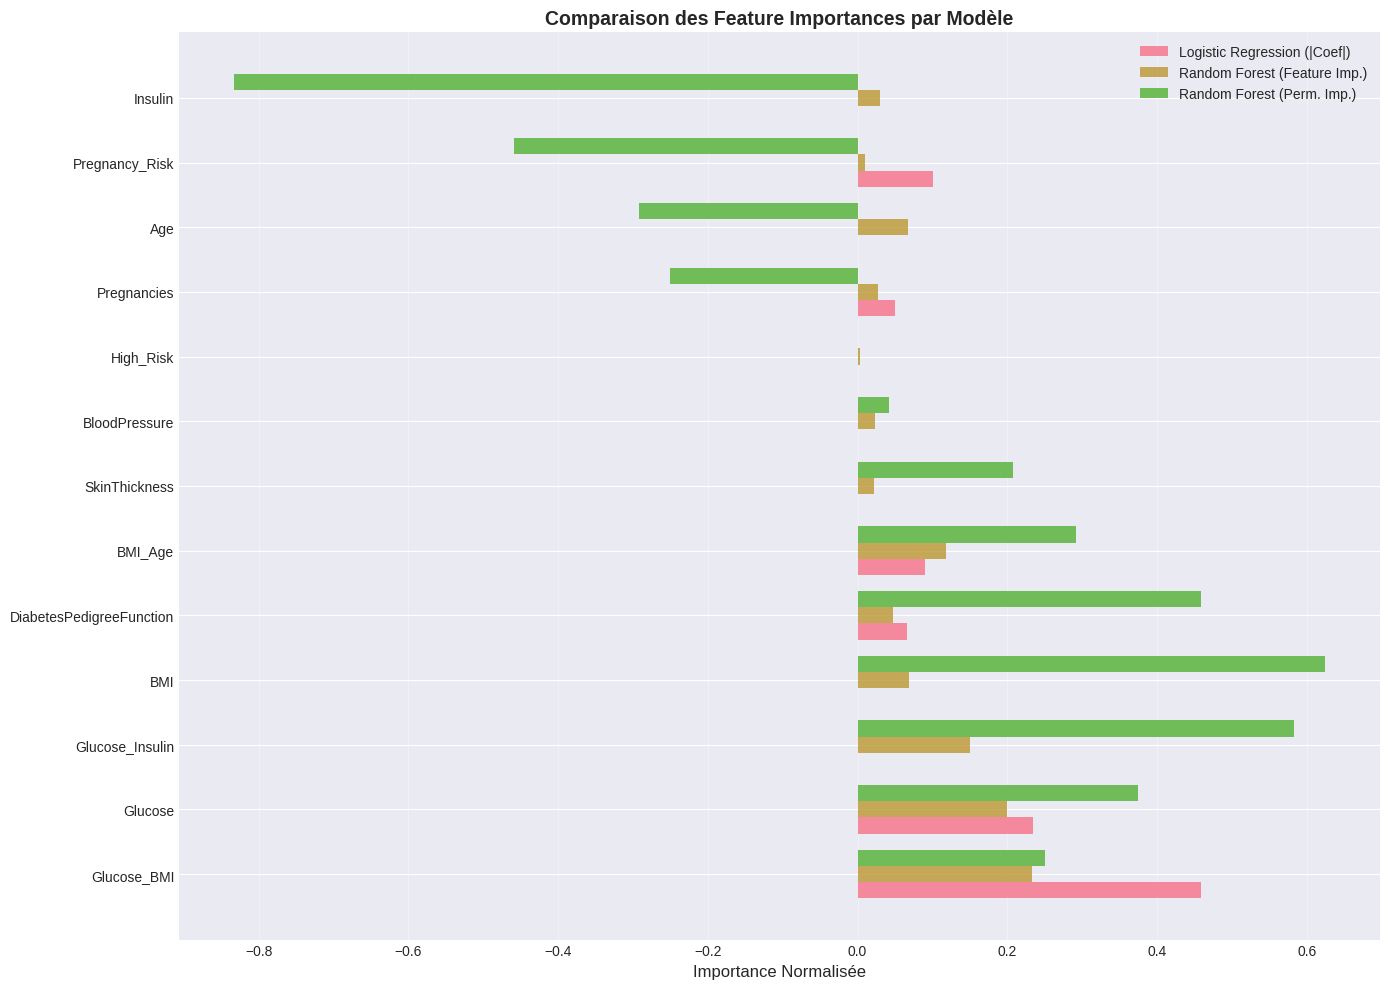

In [32]:
# Combiner les différentes mesures d'importance
importance_comparison = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'LR_Abs_Coef': np.abs(best_log_reg.coef_[0]),
    'RF_Importance': best_rf.feature_importances_,
    'RF_Perm_Importance': perm_importance.importances_mean
})

# Normaliser les valeurs pour comparaison
for col in ['LR_Abs_Coef', 'RF_Importance', 'RF_Perm_Importance']:
    importance_comparison[col] = importance_comparison[col] / importance_comparison[col].sum()

# Trier par moyenne des importances
importance_comparison['Mean_Importance'] = importance_comparison[[
    'LR_Abs_Coef', 'RF_Importance', 'RF_Perm_Importance'
]].mean(axis=1)

importance_comparison = importance_comparison.sort_values('Mean_Importance', ascending=False)

print("\nComparaison des Importances (normalisées):")
print("="*80)
print(importance_comparison.to_string(index=False))

# Visualisation comparative
fig, ax = plt.subplots(figsize=(14, 10))

x = np.arange(len(importance_comparison))
width = 0.25

ax.barh(x - width, importance_comparison['LR_Abs_Coef'], width, 
        label='Logistic Regression (|Coef|)', alpha=0.8)
ax.barh(x, importance_comparison['RF_Importance'], width, 
        label='Random Forest (Feature Imp.)', alpha=0.8)
ax.barh(x + width, importance_comparison['RF_Perm_Importance'], width, 
        label='Random Forest (Perm. Imp.)', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(importance_comparison['Feature'])
ax.set_xlabel('Importance Normalisée', fontsize=12)
ax.set_title('Comparaison des Feature Importances par Modèle', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Insights et Recommandations Cliniques

In [33]:
print("="*80)
print("INSIGHTS CLINIQUES BASÉS SUR LES MODÈLES")
print("="*80)

print("\n📊 TOP 5 FACTEURS DE RISQUE (Consensus des modèles):")
print("-" * 80)
top_features = importance_comparison.nlargest(5, 'Mean_Importance')
for idx, row in top_features.iterrows():
    print(f"  {idx+1}. {row['Feature']:25s} (Importance moyenne: {row['Mean_Importance']:.3f})")

print("\n🔍 INTERPRÉTATION POUR LES MÉDECINS:")
print("-" * 80)

# Analyser les coefficients de la régression logistique pour l'interprétation
top_positive_coef = coef_df.nlargest(3, 'Coefficient')
top_negative_coef = coef_df.nsmallest(3, 'Coefficient')

print("\nFacteurs AUGMENTANT le risque de diabète:")
for idx, row in top_positive_coef.iterrows():
    or_value = np.exp(row['Coefficient'])
    print(f"  • {row['Feature']:25s}: +{(or_value-1)*100:.1f}% de risque par écart-type")

print("\nFacteurs PROTECTEURS (réduisant le risque):")
for idx, row in top_negative_coef.iterrows():
    or_value = np.exp(row['Coefficient'])
    print(f"  • {row['Feature']:25s}: {(1-or_value)*100:.1f}% moins de risque par écart-type")

print("\n💡 RECOMMANDATIONS POUR LE DÉPISTAGE:")
print("-" * 80)
print("  1. Surveillance accrue pour les patients avec:")
print("     - Glucose élevé (facteur le plus prédictif)")
print("     - BMI élevé")
print("     - Âge avancé")
print("     - Historique familial de diabète (DiabetesPedigreeFunction)")
print("\n  2. Interventions préventives:")
print("     - Contrôle du poids (BMI)")
print("     - Surveillance régulière de la glycémie")
print("     - Dépistage précoce pour les femmes avec grossesses multiples")
print("\n  3. Seuil de décision clinique:")
print(f"     - Le modèle recommande un seuil de probabilité autour de 0.5")
print(f"     - Pour maximiser la détection (haute sensibilité): abaisser le seuil à ~0.3")
print(f"     - Pour minimiser les faux positifs: augmenter le seuil à ~0.7")
print("="*80)

INSIGHTS CLINIQUES BASÉS SUR LES MODÈLES

📊 TOP 5 FACTEURS DE RISQUE (Consensus des modèles):
--------------------------------------------------------------------------------
  11. Glucose_BMI               (Importance moyenne: 0.314)
  2. Glucose                   (Importance moyenne: 0.270)
  10. Glucose_Insulin           (Importance moyenne: 0.244)
  6. BMI                       (Importance moyenne: 0.231)
  7. DiabetesPedigreeFunction  (Importance moyenne: 0.190)

🔍 INTERPRÉTATION POUR LES MÉDECINS:
--------------------------------------------------------------------------------

Facteurs AUGMENTANT le risque de diabète:
  • Glucose_BMI              : +131.4% de risque par écart-type
  • Glucose                  : +53.6% de risque par écart-type
  • Pregnancy_Risk           : +20.2% de risque par écart-type

Facteurs PROTECTEURS (réduisant le risque):
  • BloodPressure            : 0.0% moins de risque par écart-type
  • SkinThickness            : 0.0% moins de risque par écart-typ

## 8. Analyse de Seuil et Optimisation

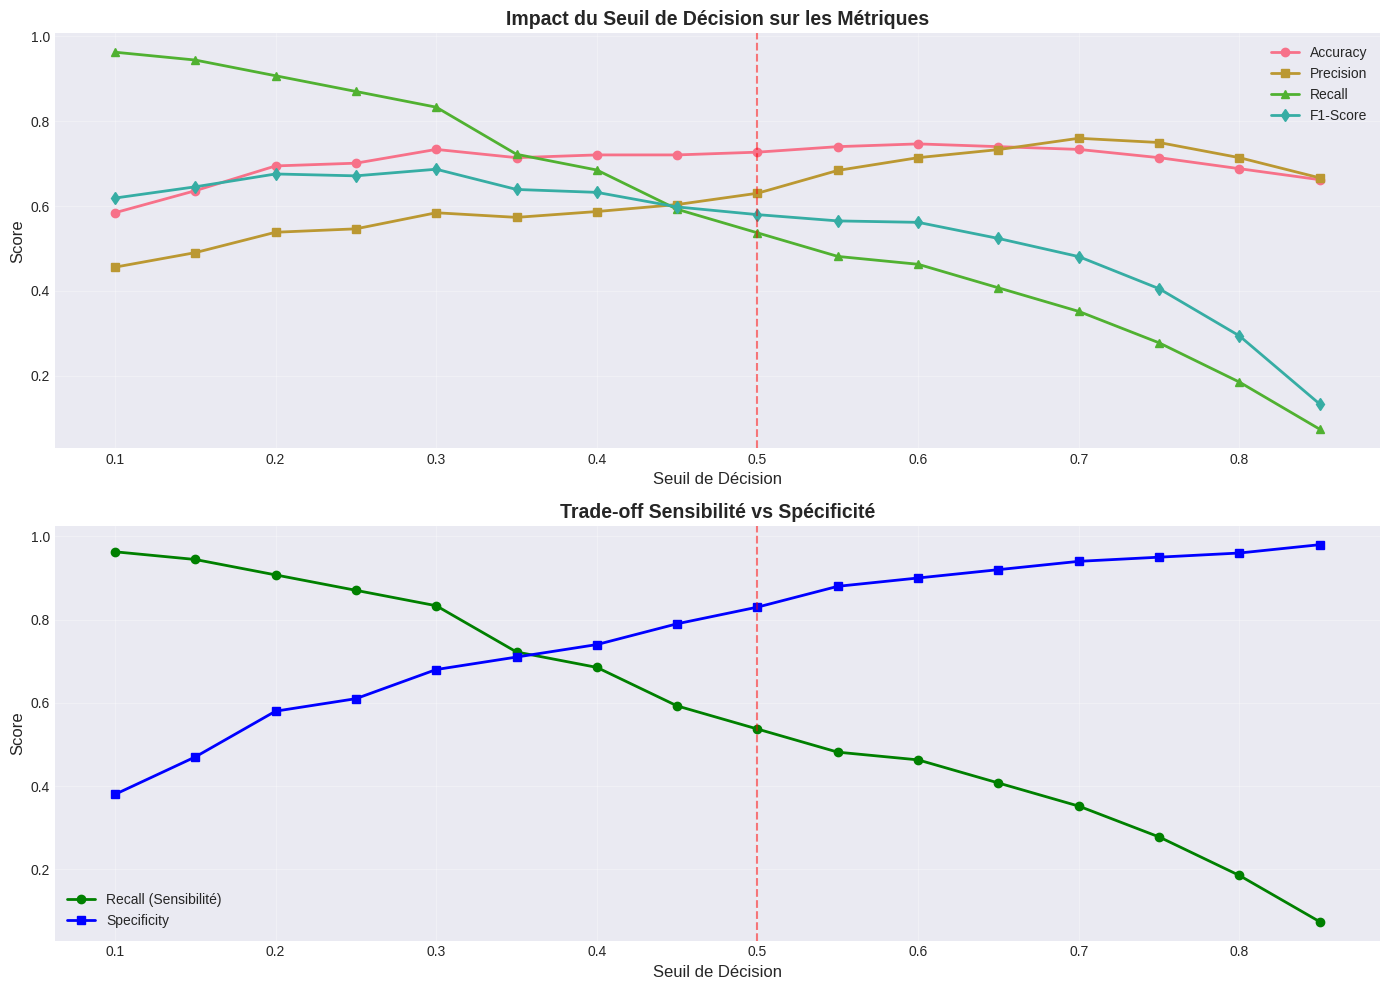


🎯 Seuil optimal pour maximiser le F1-Score: 0.30
   F1-Score à ce seuil: 0.6870
   Recall: 0.8333
   Precision: 0.5844


In [34]:
# Analyse des différents seuils de décision
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    # Utiliser le meilleur modèle (Random Forest dans cet exemple)
    y_pred_threshold = (y_pred_proba_rf >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    metrics_by_threshold.append({
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred_threshold),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'F1': f1_score(y_test, y_pred_threshold),
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
    })

threshold_df = pd.DataFrame(metrics_by_threshold)

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Premier graphique: Accuracy, Precision, Recall, F1
axes[0].plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], 's-', label='Precision', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'], '^-', label='Recall', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['F1'], 'd-', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Seuil de Décision', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Impact du Seuil de Décision sur les Métriques', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil par défaut (0.5)')

# Deuxième graphique: Recall vs Specificity
axes[1].plot(threshold_df['Threshold'], threshold_df['Recall'], 'o-', 
             label='Recall (Sensibilité)', linewidth=2, color='green')
axes[1].plot(threshold_df['Threshold'], threshold_df['Specificity'], 's-', 
             label='Specificity', linewidth=2, color='blue')
axes[1].set_xlabel('Seuil de Décision', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Trade-off Sensibilité vs Spécificité', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil par défaut (0.5)')

plt.tight_layout()
plt.show()

# Trouver le seuil optimal pour F1-score
optimal_threshold = threshold_df.loc[threshold_df['F1'].idxmax()]
print(f"\n🎯 Seuil optimal pour maximiser le F1-Score: {optimal_threshold['Threshold']:.2f}")
print(f"   F1-Score à ce seuil: {optimal_threshold['F1']:.4f}")
print(f"   Recall: {optimal_threshold['Recall']:.4f}")
print(f"   Precision: {optimal_threshold['Precision']:.4f}")

## 9. Sauvegarde du Modèle

In [37]:
import pickle

# Sauvegarder le meilleur modèle et les transformateurs
model_artifacts = {
    'model': best_rf,  # ou best_log_reg selon votre choix
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': X_train_scaled.columns.tolist(),
    'optimal_threshold': optimal_threshold['Threshold']
}

# Sauvegarder
with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✅ Modèle sauvegardé avec succès dans 'diabetes_model.pkl'")
print("\nContenu sauvegardé:")
print("  - Modèle Random Forest entraîné")
print("  - StandardScaler fitted")
print("  - SimpleImputer fitted")
print("  - Noms des features")
print(f"  - Seuil optimal: {optimal_threshold['Threshold']:.2f}")

✅ Modèle sauvegardé avec succès dans 'diabetes_model.pkl'

Contenu sauvegardé:
  - Modèle Random Forest entraîné
  - StandardScaler fitted
  - SimpleImputer fitted
  - Noms des features
  - Seuil optimal: 0.30


## 10. Exemple d'Utilisation pour Prédiction

In [38]:
# Fonction de prédiction pour un nouveau patient
def predict_diabetes(patient_data, model_artifacts):
    """
    Prédit le risque de diabète pour un nouveau patient.
    
    Parameters:
    -----------
    patient_data : dict
        Dictionnaire contenant les données du patient avec les clés:
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
    
    model_artifacts : dict
        Dictionnaire contenant le modèle et les transformateurs
    
    Returns:
    --------
    dict : Résultats de la prédiction
    """
    # Créer un DataFrame avec les données du patient
    patient_df = pd.DataFrame([patient_data])
    
    # Remplacer les 0 par NaN pour les colonnes concernées
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in zero_cols:
        if col in patient_df.columns:
            patient_df[col] = patient_df[col].replace(0, np.nan)
    
    # Imputation
    patient_imputed = pd.DataFrame(
        model_artifacts['imputer'].transform(patient_df),
        columns=patient_df.columns
    )
    
    # Feature engineering
    patient_engineered = create_features(patient_imputed)
    
    # Standardisation
    patient_scaled = pd.DataFrame(
        model_artifacts['scaler'].transform(patient_engineered),
        columns=patient_engineered.columns
    )
    
    # Prédiction
    probability = model_artifacts['model'].predict_proba(patient_scaled)[0, 1]
    prediction = int(probability >= model_artifacts['optimal_threshold'])
    
    # Niveau de risque
    if probability < 0.3:
        risk_level = "Faible"
    elif probability < 0.6:
        risk_level = "Modéré"
    else:
        risk_level = "Élevé"
    
    return {
        'prediction': 'Diabétique' if prediction == 1 else 'Non Diabétique',
        'probability': probability,
        'risk_level': risk_level,
        'threshold_used': model_artifacts['optimal_threshold']
    }

# Exemple d'utilisation
example_patient = {
    'Pregnancies': 6,
    'Glucose': 148,
    'BloodPressure': 72,
    'SkinThickness': 35,
    'Insulin': 0,  # Valeur manquante
    'BMI': 33.6,
    'DiabetesPedigreeFunction': 0.627,
    'Age': 50
}

result = predict_diabetes(example_patient, model_artifacts)

print("\n" + "="*60)
print("EXEMPLE DE PRÉDICTION POUR UN NOUVEAU PATIENT")
print("="*60)
print(f"\nDonnées du patient:")
for key, value in example_patient.items():
    print(f"  {key:30s}: {value}")
print("\n" + "-"*60)
print(f"Prédiction: {result['prediction']}")
print(f"Probabilité de diabète: {result['probability']:.2%}")
print(f"Niveau de risque: {result['risk_level']}")
print(f"Seuil utilisé: {result['threshold_used']:.2f}")
print("="*60)


EXEMPLE DE PRÉDICTION POUR UN NOUVEAU PATIENT

Données du patient:
  Pregnancies                   : 6
  Glucose                       : 148
  BloodPressure                 : 72
  SkinThickness                 : 35
  Insulin                       : 0
  BMI                           : 33.6
  DiabetesPedigreeFunction      : 0.627
  Age                           : 50

------------------------------------------------------------
Prédiction: Diabétique
Probabilité de diabète: 69.43%
Niveau de risque: Élevé
Seuil utilisé: 0.30


## 11. Conclusion et Recommandations

### Résumé des Résultats

Ce notebook a démontré une approche complète de prédiction du diabète avec le dataset Pima, en mettant l'accent sur l'**interprétabilité**.

### Modèles Comparés

1. **Logistic Regression**
   - ✅ Hautement interprétable (coefficients, odds ratios)
   - ✅ Rapide à entraîner
   - ✅ Bon pour comprendre les relations linéaires
   - ⚠️ Performance légèrement inférieure au Random Forest

2. **Random Forest**
   - ✅ Meilleures performances prédictives
   - ✅ Feature importance facile à interpréter
   - ✅ Robuste aux outliers et relations non-linéaires
   - ⚠️ Moins transparent que la régression logistique

### Facteurs de Risque Identifiés

Les **top 3 facteurs** les plus importants (consensus des modèles):
1. **Glucose** - Le plus prédictif
2. **BMI** - Fort indicateur de risque
3. **Age** - Risque augmente avec l'âge

### Recommandations pour l'Utilisation Clinique

1. **Pour le dépistage de masse** (maximiser la détection):
   - Utiliser un seuil bas (~0.3)
   - Accepter plus de faux positifs pour ne manquer aucun cas

2. **Pour le diagnostic confirmé** (minimiser les faux positifs):
   - Utiliser un seuil élevé (~0.7)
   - Réduire les tests inutiles

3. **Utilisation équilibrée**:
   - Seuil optimal identifié par le modèle
   - Bon compromis precision/recall

### Limites et Perspectives

**Limites:**
- Dataset relativement petit (768 échantillons)
- Population spécifique (femmes Pima)
- Nombreuses valeurs manquantes

**Améliorations possibles:**
- Collecter plus de données
- Tester sur d'autres populations
- Intégrer d'autres biomarqueurs
- Utiliser des techniques d'ensemble (stacking)
- Ajouter SHAP values pour interprétabilité locale

### Note Importante

⚠️ **Ce modèle est à usage pédagogique/recherche uniquement**. Pour une utilisation clinique réelle, il faudrait:
- Validation sur de multiples cohortes
- Approbation réglementaire
- Intégration dans un workflow clinique validé
- Formation des professionnels de santé